<a href="https://colab.research.google.com/github/thiago2608santana/Analise_Series_Temporais/blob/main/Deep_Learning_in_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

**Definir parâmetros iniciais das figuras para todos os plots**

In [2]:
plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False

In [3]:
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape, RNN, LSTMCell

In [4]:
print(tf.__version__)

2.8.2


In [5]:
tf.random.set_seed(51)
np.random.seed(51)

## Appliance Energy Dataset

In [6]:
df = pd.read_csv('/content/drive/MyDrive/Analise_Series_Temporais_Datasets/energydata_complete.csv')

In [7]:
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
1,2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2,2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
3,2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
4,2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


**T1..T9 são as temperaturas provenientes dos sensores 1 a 9. RH1...RH9 segue a mesma lógica das temperaturas, porém está relacionado à humidade**

In [8]:
df = df[::6]
df.head()

,date,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,2016-01-11 17:00:00,60,30,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,13.275433,13.275433
6,2016-01-11 18:00:00,60,50,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,47.233763,47.233763
12,2016-01-11 19:00:00,430,50,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,34.351142,34.351142
18,2016-01-11 20:00:00,80,30,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,19.001759,19.001759
24,2016-01-11 21:00:00,110,30,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,13.361033,13.361033


In [9]:
df.shape

(3290, 29)

In [10]:
date_time = pd.to_datetime(df.pop('date'), format='%Y.%m.%d %H:%M:%S')

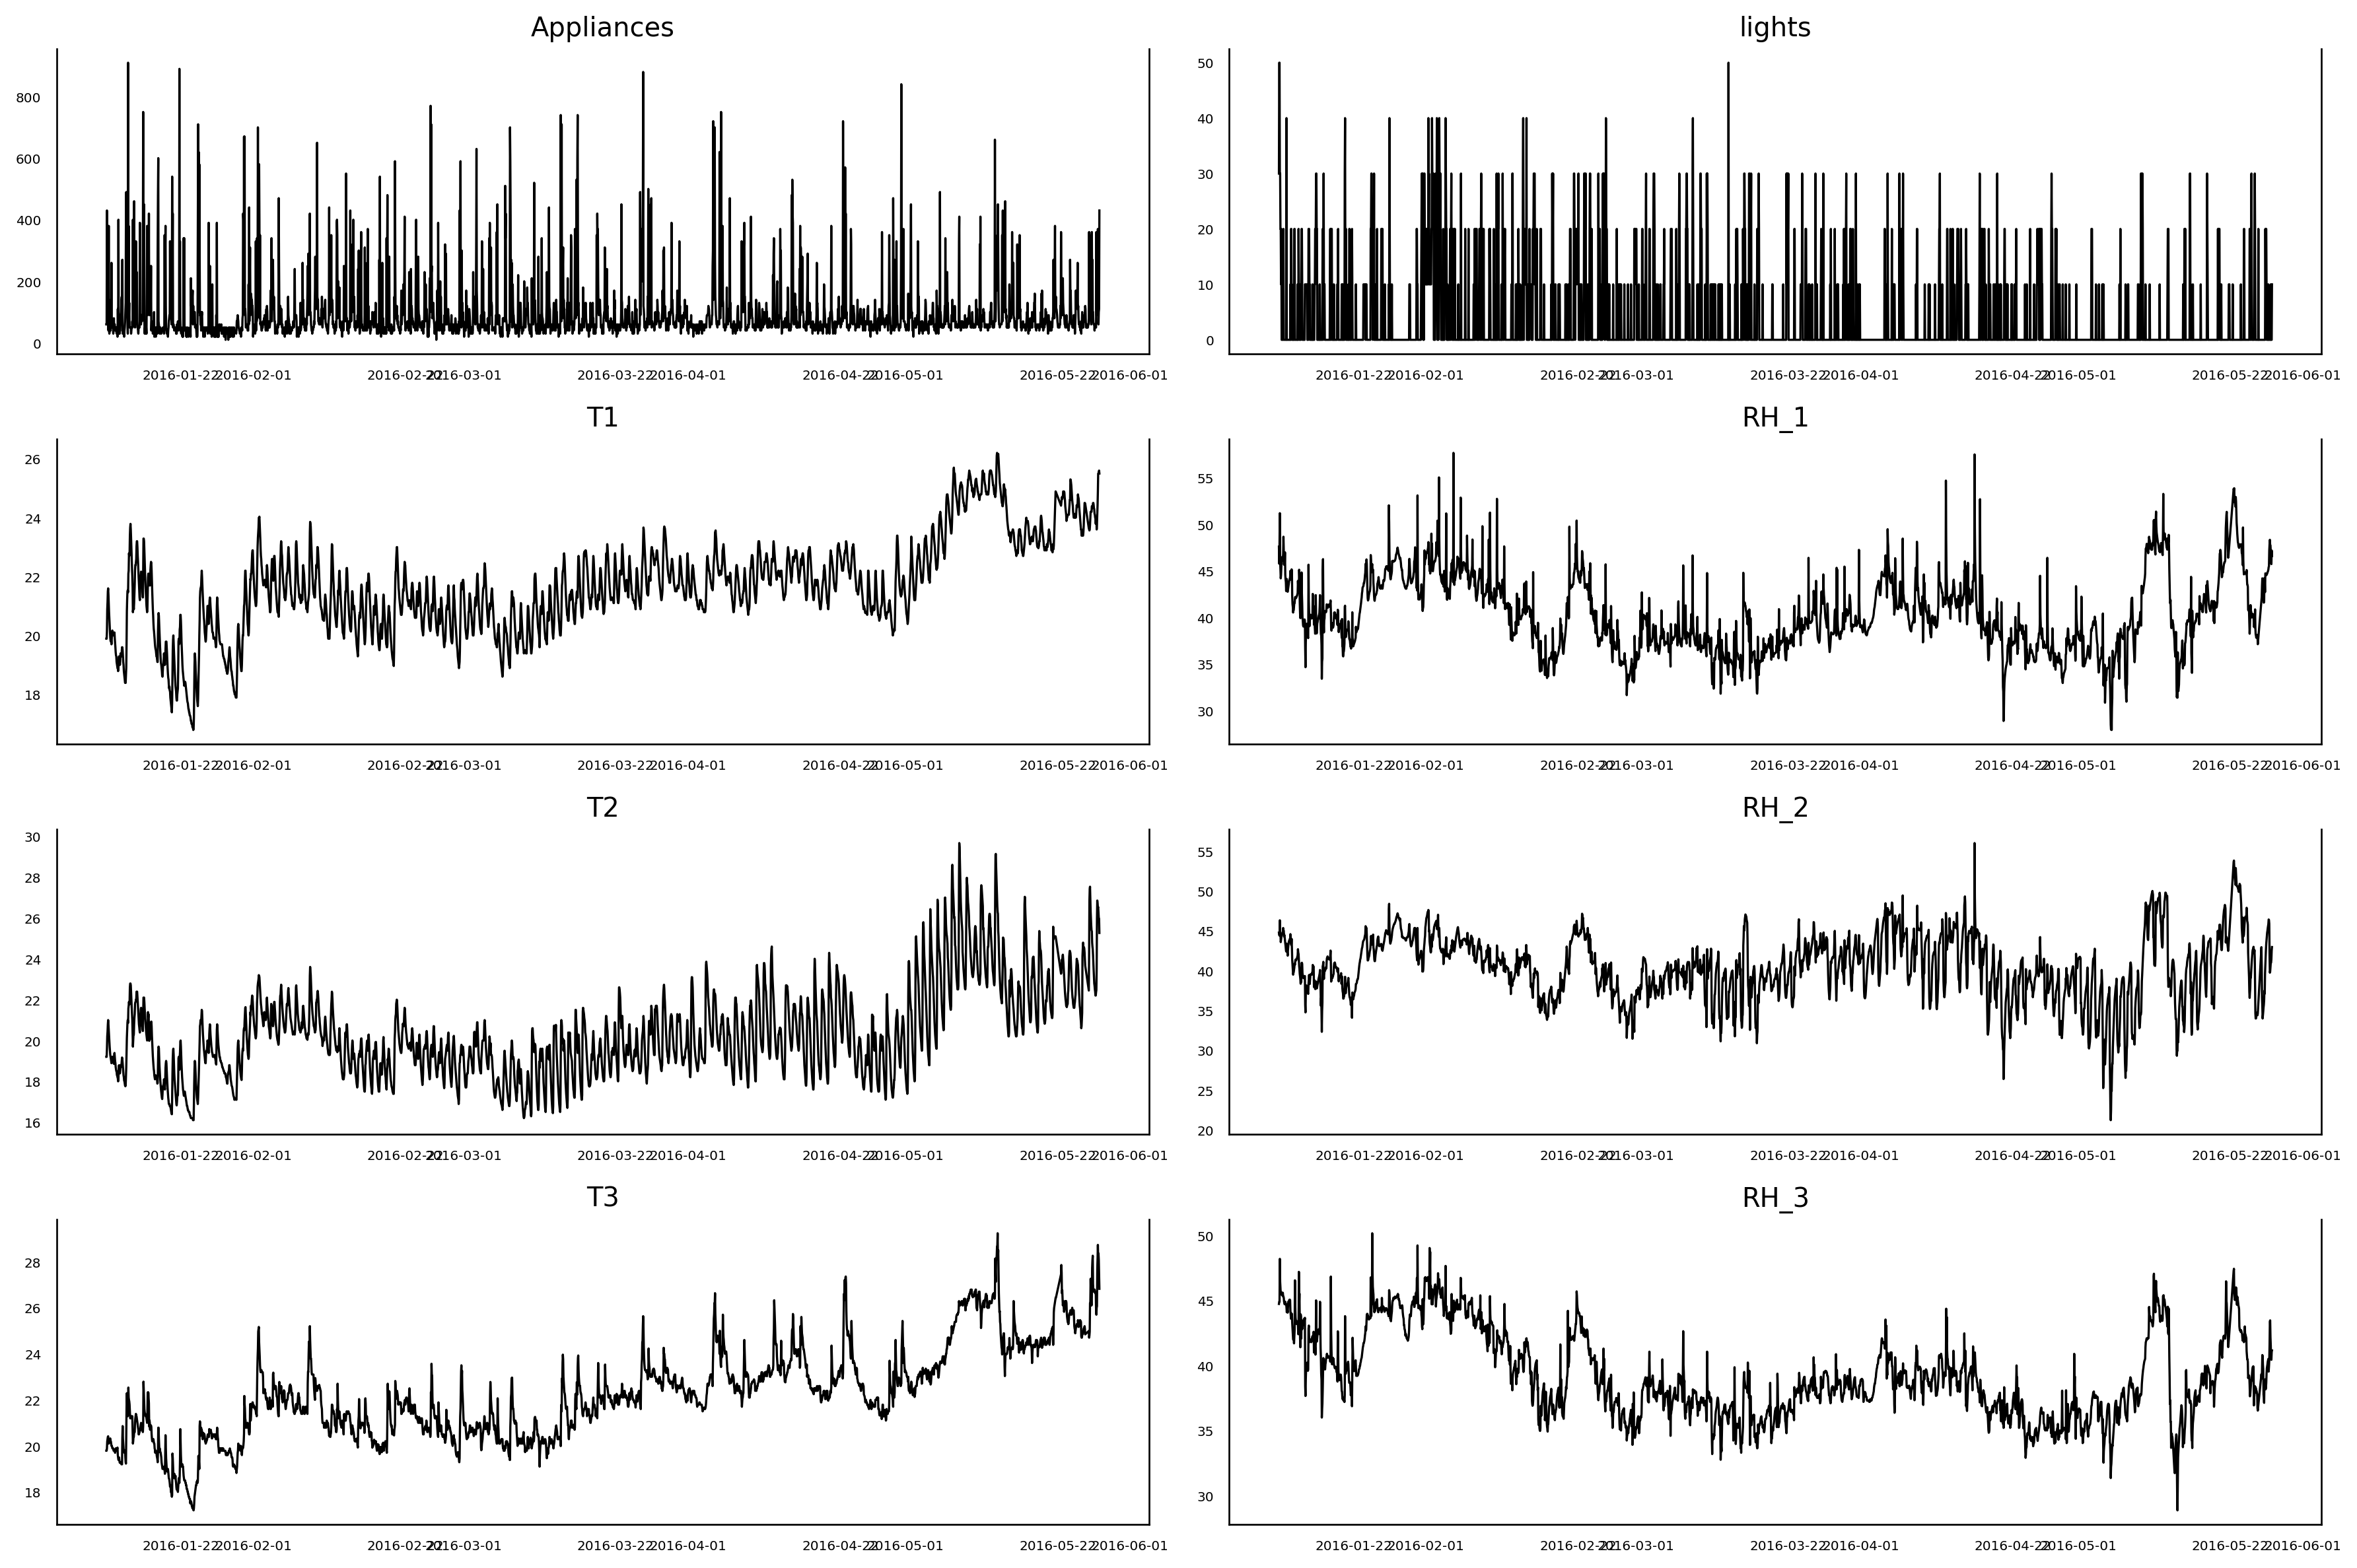

In [11]:
fig, axes = plt.subplots(nrows=4, ncols=2, dpi=240, figsize=(15, 10))

for i, ax in enumerate(axes.flatten()):
  data = df[df.columns[i]]
  data.index = date_time
  ax.plot(data, color='black', linewidth=1)
  ax.set_title(df.columns[i])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize=6)

plt.tight_layout()

## Exploratory Data Analysis

In [12]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Appliances,3290.0,96.835866,100.459209,10.000000,50.000000,60.000000,100.000000,910.000000
lights,3290.0,3.802432,7.954943,0.000000,0.000000,0.000000,0.000000,50.000000
T1,3290.0,21.686138,1.606259,16.790000,20.737500,21.600000,22.600000,26.200000
RH_1,3290.0,40.262549,3.992042,27.926667,37.372500,39.650833,43.090000,57.663333
T2,3290.0,20.342054,2.195577,16.100000,18.790000,20.000000,21.500000,29.663333
RH_2,3290.0,40.423351,4.072868,21.230000,37.888750,40.500000,43.260000,56.026667
T3,3290.0,22.266861,2.006131,17.200000,20.790000,22.100000,23.290000,29.236000
RH_3,3290.0,39.241405,3.254206,28.860000,36.900000,38.537500,41.752500,50.163333
T4,3290.0,20.856308,2.043188,15.100000,19.500000,20.633333,22.100000,26.140000
RH_4,3290.0,39.026112,4.343764,28.424286,35.527500,38.400000,42.152500,50.963333


**A variável lights contém muitos valores nulos. rv1 e rv2 são variáveis aleatórias e não contém poder preditivo**

In [13]:
drop_cols = ['lights', 'rv1', 'rv2']
df.drop(drop_cols, axis = 1, inplace = True)

In [14]:
df.shape

(3290, 25)

In [15]:
df.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T8,RH_8,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint
0,60,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,...,18.200000,48.90,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3
6,60,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,...,18.100000,48.59,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7
12,430,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,...,18.066667,48.56,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6
18,80,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,...,18.533333,50.20,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1
24,110,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,...,19.000000,49.76,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9


## Feature Engineering

### Time

In [16]:
timestamp_s = date_time.map(datetime.datetime.timestamp)

In [17]:
fft = tf.signal.rfft(df['Appliances'])
f_per_dataset = np.arange(0, len(fft))
n_sample_h = len(df['Appliances'])
#Quantidade média de dias em um mês: 30.4167
hours_per_month = 24 * 30.4167
months_per_dataset = n_sample_h / hours_per_month
f_per_month = f_per_dataset / months_per_dataset

Text(0.5, 0, 'Frequency')

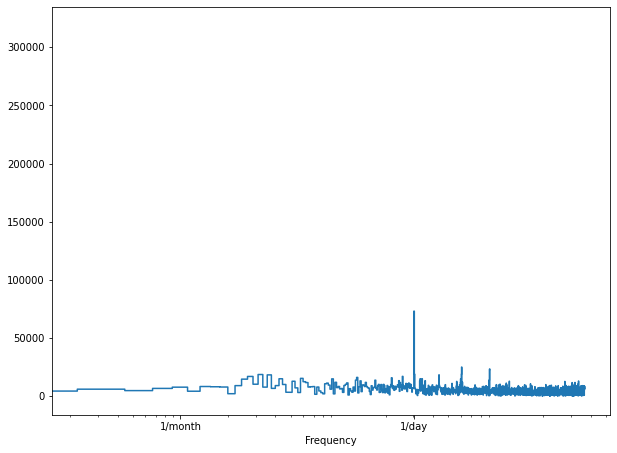

In [18]:
plt.step(f_per_month, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 30.4167], labels=['1/month', '1/day'])
plt.xlabel('Frequency')

In [19]:
day = 24 * 60 * 60

df['Day sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['Day cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values

In [20]:
df.head()

,Appliances,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,T5,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,Day sin,Day cos
0,60,19.890000,47.596667,19.200000,44.79,19.79,44.730000,19.000000,45.566667,17.166667,...,17.033333,45.530000,6.6,733.5,92.0,7.0,63.0,5.3,-0.965926,-2.588190e-01
6,60,19.890000,45.766667,19.200000,44.50,19.79,44.900000,18.890000,45.790000,17.100000,...,17.000000,45.290000,5.9,734.1,92.0,5.0,40.0,4.7,-1.000000,-9.768282e-12
12,430,20.133333,48.000000,19.566667,44.40,19.89,44.900000,19.000000,46.363333,17.100000,...,16.963333,45.290000,6.0,734.5,91.0,6.0,40.0,4.6,-0.965926,2.588190e-01
18,80,20.890000,51.193333,20.200000,46.33,20.20,48.193333,18.963333,48.630000,17.200000,...,16.890000,45.200000,6.0,735.2,88.0,6.0,40.0,4.1,-0.866025,5.000000e-01
24,110,21.133333,46.060000,20.426667,44.76,20.29,46.433333,19.390000,48.193333,17.760000,...,16.890000,44.966667,6.0,735.4,87.0,6.0,40.0,3.9,-0.707107,7.071068e-01


## Split Data

In [21]:
column_indices = {name : i for i, name in enumerate(df.columns)}

n = len(df)

train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

print(f'There are {num_features} features')

There are 27 features


## Standardize Data

In [22]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

In [23]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')

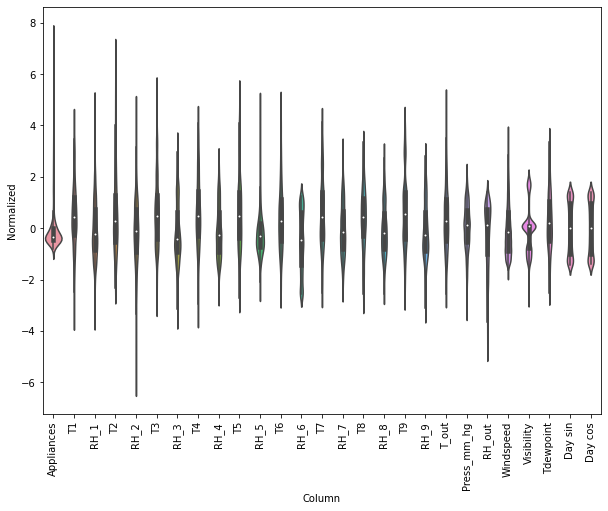

In [24]:
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

## Data Windowing

In [25]:
class WindowGenerator():

  def __init__(self, input_width, label_width, shift, train_df=train_df, val_df=val_df, test_df=test_df, label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    
    # Work out the label column indices.
    self.label_columns=label_columns
    if label_columns is not None:
      self.label_columns_indices = {name : i for i, name in enumerate(label_columns)}

    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])
    
  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]

    if self.label_columns is not None:
      labels = tf.stack(
          [labels[:, :, self.column_indices[name]] for name in self.label_columns], axis = -1
      )
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Appliances', max_subplots=3):
    inputs, labels = self.example

    plt.figure(figsize=(12,8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))

    for n in range(max_n):
      plt.subplot(3, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], \
               label='Inputs', marker='.', zorder=-10)
      
      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index], \
                  edgecolor='k', label='Labels', c='#2ca02c', s=64)

      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index], \
                    marker='X', edgecolors='k', label='Predictions', \
                    c='#ff7f0e', s=64)
        
      if n == 0:
        plt.legend()

    plt.xlabel('Time (h)')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.preprocessing.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32
    )

    ds = ds.map(self.split_window)

    return ds

  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    result = getattr(self, '_example', None)
    if result is None:
      result = next(iter(self.train))
      self._example = result

    return result
    

In [27]:
MAX_EPOCHS = 50

def compile_and_fit(model, window, patience=3):
  early_stopping = EarlyStopping(monitor='val_loss',
                                 patience=patience,
                                 mode='min')
  model.compile(loss=MeanSquaredError(),
                optimizer=Adam(),
                metrics=[MeanAbsoluteError()])
  
  history = model.fit(window.train,
                      epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  
  return history

## Single Step Model

In [28]:
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Appliances'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Appliances']

### Baseline

In [29]:
class Baseline(Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]

    return result[:, :, tf.newaxis]

In [30]:
baseline = Baseline(label_index = column_indices['Appliances'])

In [31]:
baseline.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

In [32]:
val_performance = {}
performance = {}

In [33]:
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 1s 6ms/step - loss: 0.7669 - mean_absolute_error: 0.3881


In [34]:
wide_window = WindowGenerator(input_width=24, label_width=24, shift=1, label_columns=['Appliances'])
wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Appliances']

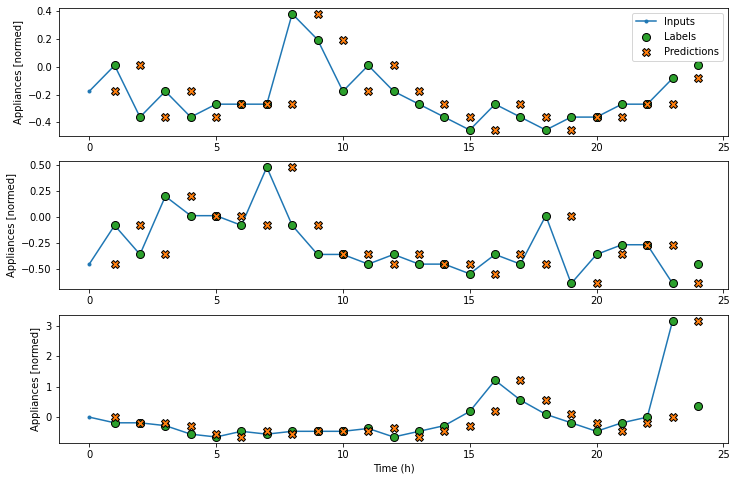

In [35]:
wide_window.plot(baseline)

### Linear Model

In [36]:
linear = Sequential([
    Dense(units=1)
])

In [37]:
history = compile_and_fit(linear, single_step_window)

Epoch 1/50
72/72 [==============================] - 2s 13ms/step - loss: 1.4879 - mean_absolute_error: 0.8501 - val_loss: 0.9282 - val_mean_absolute_error: 0.6625
Epoch 2/50
72/72 [==============================] - 1s 12ms/step - loss: 1.1573 - mean_absolute_error: 0.7031 - val_loss: 0.7960 - val_mean_absolute_error: 0.5937
Epoch 3/50
72/72 [==============================] - 1s 13ms/step - loss: 1.0575 - mean_absolute_error: 0.6455 - val_loss: 0.7141 - val_mean_absolute_error: 0.5378
Epoch 4/50
72/72 [==============================] - 1s 12ms/step - loss: 0.9965 - mean_absolute_error: 0.6091 - val_loss: 0.6680 - val_mean_absolute_error: 0.5024
Epoch 5/50
72/72 [==============================] - 1s 12ms/step - loss: 0.9551 - mean_absolute_error: 0.5842 - val_loss: 0.6292 - val_mean_absolute_error: 0.4602
Epoch 6/50
72/72 [==============================] - 1s 10ms/step - loss: 0.9256 - mean_absolute_error: 0.5662 - val_loss: 0.6099 - val_mean_absolute_error: 0.4466
Epoch 7/50
72/72 [====

In [38]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

21/21 [==============================] - 1s 9ms/step - loss: 0.5486 - mean_absolute_error: 0.3975


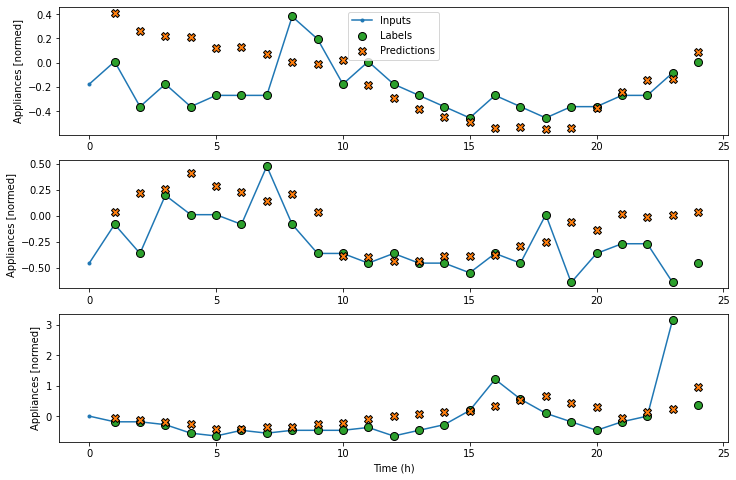

In [39]:
wide_window.plot(linear)

### Dense

In [40]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 11ms/step - loss: 0.9141 - mean_absolute_error: 0.5476 - val_loss: 0.5865 - val_mean_absolute_error: 0.5149
Epoch 2/50
72/72 [==============================] - 1s 9ms/step - loss: 0.8173 - mean_absolute_error: 0.5121 - val_loss: 0.5322 - val_mean_absolute_error: 0.3868
Epoch 3/50
72/72 [==============================] - 1s 9ms/step - loss: 0.7838 - mean_absolute_error: 0.5084 - val_loss: 0.5543 - val_mean_absolute_error: 0.4103
Epoch 4/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7666 - mean_absolute_error: 0.5062 - val_loss: 0.5668 - val_mean_absolute_error: 0.4256
Epoch 5/50
21/21 [==============================] - 0s 5ms/step - loss: 0.5746 - mean_absolute_error: 0.4328


### CNN

In [41]:
CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Appliances']
)

In [42]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Appliances'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Appliances']

In [43]:
cnn_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    Dense(units=32, activation='relu'),
    Dense(units=1)
])

history = compile_and_fit(cnn_model, conv_window)

val_performance['CNN'] = cnn_model.evaluate(conv_window.val)
performance['CNN'] = cnn_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 2s 12ms/step - loss: 0.8972 - mean_absolute_error: 0.5492 - val_loss: 0.5624 - val_mean_absolute_error: 0.4102
Epoch 2/50
72/72 [==============================] - 1s 8ms/step - loss: 0.8039 - mean_absolute_error: 0.5134 - val_loss: 0.5532 - val_mean_absolute_error: 0.3987
Epoch 3/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7649 - mean_absolute_error: 0.5059 - val_loss: 0.5753 - val_mean_absolute_error: 0.4007
Epoch 4/50
72/72 [==============================] - 1s 8ms/step - loss: 0.7453 - mean_absolute_error: 0.4851 - val_loss: 0.6147 - val_mean_absolute_error: 0.4260
Epoch 5/50
21/21 [==============================] - 0s 4ms/step - loss: 0.5886 - mean_absolute_error: 0.3957


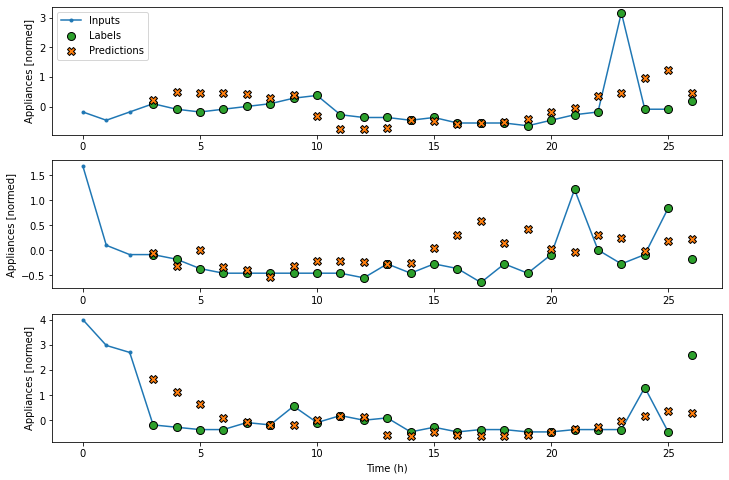

In [44]:
wide_conv_window.plot(cnn_model)

### LSTM

In [45]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=1)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 5s 30ms/step - loss: 0.8948 - mean_absolute_error: 0.5390 - val_loss: 0.5720 - val_mean_absolute_error: 0.4022
Epoch 2/50
72/72 [==============================] - 2s 21ms/step - loss: 0.7566 - mean_absolute_error: 0.4881 - val_loss: 0.5800 - val_mean_absolute_error: 0.4154
Epoch 3/50
72/72 [==============================] - 1s 20ms/step - loss: 0.6927 - mean_absolute_error: 0.4662 - val_loss: 0.5924 - val_mean_absolute_error: 0.4258
Epoch 4/50
20/20 [==============================] - 0s 9ms/step - loss: 0.6088 - mean_absolute_error: 0.4374


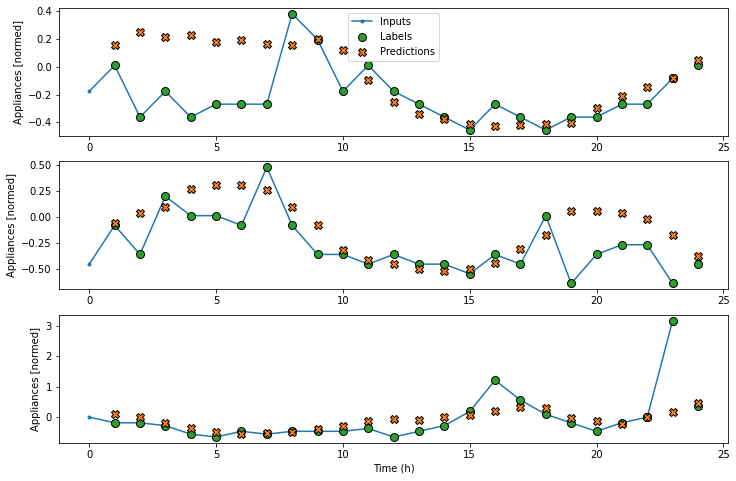

In [46]:
wide_window.plot(lstm_model)

In [47]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 7s 27ms/step - loss: 0.9669 - mean_absolute_error: 0.5513 - val_loss: 0.5596 - val_mean_absolute_error: 0.3985
Epoch 2/50
72/72 [==============================] - 1s 13ms/step - loss: 0.8345 - mean_absolute_error: 0.5014 - val_loss: 0.5829 - val_mean_absolute_error: 0.3829
Epoch 3/50
72/72 [==============================] - 1s 14ms/step - loss: 0.7815 - mean_absolute_error: 0.4837 - val_loss: 0.5467 - val_mean_absolute_error: 0.3479
Epoch 4/50
72/72 [==============================] - 1s 12ms/step - loss: 0.7549 - mean_absolute_error: 0.4682 - val_loss: 0.5474 - val_mean_absolute_error: 0.3353
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 0.7315 - mean_absolute_error: 0.4619 - val_loss: 0.5722 - val_mean_absolute_error: 0.3422
Epoch 6/50
21/21 [==============================] - 0s 4ms/step - loss: 0.5687 - mean_absolute_error: 0.3379


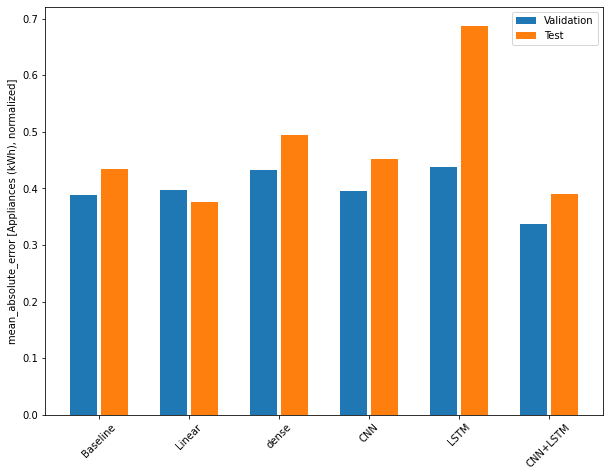

In [48]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Appliances (kWh), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [49]:
for name, value in performance.items():
    print(f'{name}: {value[1]:0.4f}')

Baseline: 0.4342
Linear: 0.3754
dense: 0.4950
CNN: 0.4520
LSTM: 0.6863
CNN+LSTM: 0.3905


## Mult-Output Models

In [50]:
single_step_window = WindowGenerator(
    input_width=1,
    label_width=1,
    shift=1
)

wide_window = WindowGenerator(
    input_width=24,
    label_width=24,
    shift=1
)

CONV_WIDTH = 3

conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1
)

for example_inputs, example_labels in wide_window.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
    print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 24, 27)
Labels shape (batch, time, features): (32, 24, 27)


### Baseline

In [51]:
baseline = Baseline()
baseline.compile(loss=MeanSquaredError(),
                metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['baseline'] = baseline.evaluate(wide_window.val)
performance['baseline'] = baseline.evaluate(wide_window.test, verbose=0)

20/20 [==============================] - 1s 9ms/step - loss: 0.1296 - mean_absolute_error: 0.1775


### Dense

In [52]:
dense = Sequential([
    Dense(units=64, activation='relu'),
    Dense(units=64, activation='relu'),
    Dense(units=num_features)
])

history = compile_and_fit(dense, single_step_window)

val_performance['dense'] = dense.evaluate(single_step_window.val)
performance['dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 3s 18ms/step - loss: 0.5956 - mean_absolute_error: 0.5888 - val_loss: 0.5116 - val_mean_absolute_error: 0.5373
Epoch 2/50
72/72 [==============================] - 1s 14ms/step - loss: 0.2720 - mean_absolute_error: 0.3736 - val_loss: 0.3536 - val_mean_absolute_error: 0.4391
Epoch 3/50
72/72 [==============================] - 1s 14ms/step - loss: 0.2056 - mean_absolute_error: 0.3130 - val_loss: 0.2808 - val_mean_absolute_error: 0.3843
Epoch 4/50
72/72 [==============================] - 1s 15ms/step - loss: 0.1764 - mean_absolute_error: 0.2816 - val_loss: 0.2421 - val_mean_absolute_error: 0.3537
Epoch 5/50
72/72 [==============================] - 1s 9ms/step - loss: 0.1600 - mean_absolute_error: 0.2618 - val_loss: 0.2345 - val_mean_absolute_error: 0.3464
Epoch 6/50
72/72 [==============================] - 1s 8ms/step - loss: 0.1496 - mean_absolute_error: 0.2486 - val_loss: 0.2138 - val_mean_absolute_error: 0.3266
Epoch 7/50
72/72 [======

### LSTM

In [53]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 6s 27ms/step - loss: 0.7021 - mean_absolute_error: 0.6514 - val_loss: 1.2755 - val_mean_absolute_error: 0.8182
Epoch 2/50
72/72 [==============================] - 1s 20ms/step - loss: 0.3738 - mean_absolute_error: 0.4534 - val_loss: 0.8767 - val_mean_absolute_error: 0.6697
Epoch 3/50
72/72 [==============================] - 2s 20ms/step - loss: 0.2775 - mean_absolute_error: 0.3765 - val_loss: 0.7348 - val_mean_absolute_error: 0.6073
Epoch 4/50
72/72 [==============================] - 2s 20ms/step - loss: 0.2317 - mean_absolute_error: 0.3341 - val_loss: 0.6366 - val_mean_absolute_error: 0.5625
Epoch 5/50
72/72 [==============================] - 1s 19ms/step - loss: 0.2026 - mean_absolute_error: 0.3050 - val_loss: 0.5634 - val_mean_absolute_error: 0.5253
Epoch 6/50
72/72 [==============================] - 2s 23ms/step - loss: 0.1813 - mean_absolute_error: 0.2822 - val_loss: 0.5062 - val_mean_absolute_error: 0.4941
Epoch 7/50
72/72 [====

### CNN + LSTM

In [54]:
cnn_lstm_model = Sequential([
    Conv1D(filters=32, 
           kernel_size=(CONV_WIDTH,), 
           activation='relu'),
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=True),
    Dense(1)
])

history = compile_and_fit(cnn_lstm_model, conv_window)

val_performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.val)
performance['CNN+LSTM'] = cnn_lstm_model.evaluate(conv_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 8s 29ms/step - loss: 0.8656 - mean_absolute_error: 0.7412 - val_loss: 1.9519 - val_mean_absolute_error: 1.1164
Epoch 2/50
72/72 [==============================] - 1s 14ms/step - loss: 0.8266 - mean_absolute_error: 0.7212 - val_loss: 1.9353 - val_mean_absolute_error: 1.1134
Epoch 3/50
72/72 [==============================] - 1s 12ms/step - loss: 0.8249 - mean_absolute_error: 0.7203 - val_loss: 1.9225 - val_mean_absolute_error: 1.1101
Epoch 4/50
72/72 [==============================] - 1s 10ms/step - loss: 0.8241 - mean_absolute_error: 0.7201 - val_loss: 1.9183 - val_mean_absolute_error: 1.1094
Epoch 5/50
72/72 [==============================] - 1s 11ms/step - loss: 0.8236 - mean_absolute_error: 0.7199 - val_loss: 1.9184 - val_mean_absolute_error: 1.1083
Epoch 6/50
72/72 [==============================] - 1s 12ms/step - loss: 0.8233 - mean_absolute_error: 0.7197 - val_loss: 1.9103 - val_mean_absolute_error: 1.1072
Epoch 7/50
72/72 [====

### Resnet

In [55]:
class ResidualWrapper(Model):
    def __init__(self, model):
        super().__init__()
        self.model = model
        
    def call(self, inputs, *args, **kwargs):
        delta = self.model(inputs, *args, **kwargs)
        
        return inputs + delta

In [56]:
res_lstm = ResidualWrapper(
    Sequential([
        LSTM(32, return_sequences=True),
        Dense(
            num_features,
            kernel_initializer=tf.initializers.zeros    # Initialize predictions to 0
        )
    ])
)

history = compile_and_fit(res_lstm, wide_window)

val_performance['res_lstm'] = res_lstm.evaluate(wide_window.val)
performance['res_lstm'] = res_lstm.evaluate(wide_window.test, verbose=0)

Epoch 1/50
72/72 [==============================] - 10s 50ms/step - loss: 0.1475 - mean_absolute_error: 0.1689 - val_loss: 0.1124 - val_mean_absolute_error: 0.1591
Epoch 2/50
72/72 [==============================] - 2s 30ms/step - loss: 0.1296 - mean_absolute_error: 0.1577 - val_loss: 0.1032 - val_mean_absolute_error: 0.1609
Epoch 3/50
72/72 [==============================] - 3s 36ms/step - loss: 0.1117 - mean_absolute_error: 0.1543 - val_loss: 0.0993 - val_mean_absolute_error: 0.1616
Epoch 4/50
72/72 [==============================] - 2s 21ms/step - loss: 0.1032 - mean_absolute_error: 0.1527 - val_loss: 0.1004 - val_mean_absolute_error: 0.1641
Epoch 5/50
72/72 [==============================] - 1s 20ms/step - loss: 0.0985 - mean_absolute_error: 0.1513 - val_loss: 0.1016 - val_mean_absolute_error: 0.1652
Epoch 6/50
20/20 [==============================] - 0s 7ms/step - loss: 0.1028 - mean_absolute_error: 0.1674


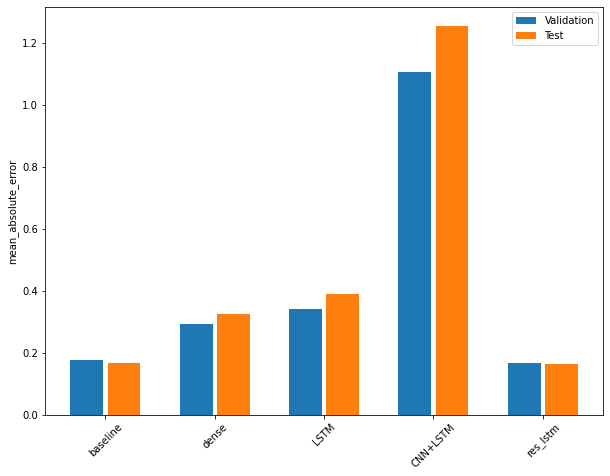

In [57]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.legend(loc='best')
plt.show()

In [58]:
for name, value in performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

baseline    : 0.1658
dense       : 0.3241
LSTM        : 0.3904
CNN+LSTM    : 1.2532
res_lstm    : 0.1624


## Multi-Step Models

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

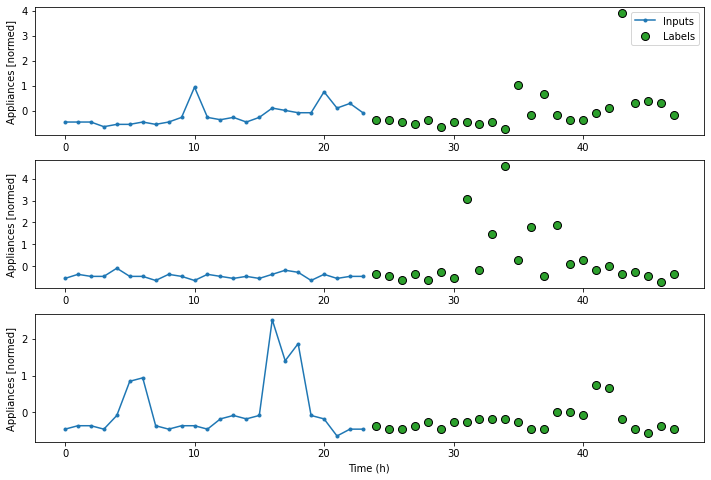

In [59]:
OUT_STEPS = 24

multi_window = WindowGenerator(input_width=24,
                              label_width=OUT_STEPS,
                              shift=OUT_STEPS)

multi_window.plot()
multi_window

### Baseline

In [60]:
class MultiStepLastBaseline(Model):
    def call(self, inputs):
        return tf.tile(inputs[:,-1:,:], [1, OUT_STEPS, 1])

In [61]:
last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=MeanSquaredError(),
                     metrics=[MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 0s 6ms/step - loss: 0.9511 - mean_absolute_error: 0.6514


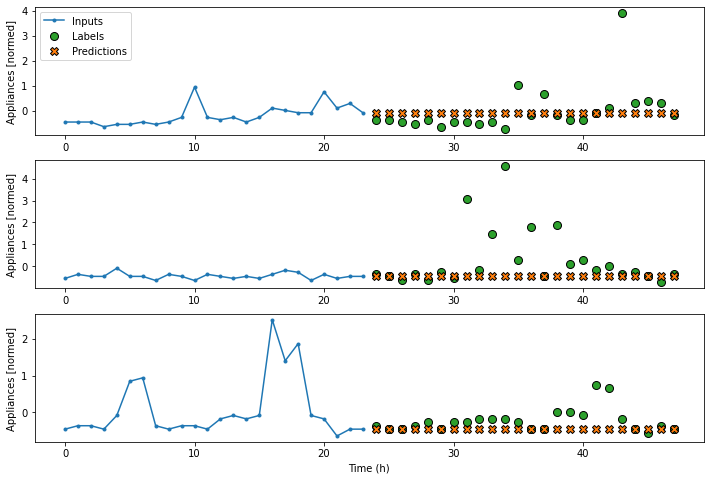

In [62]:
multi_window.plot(last_baseline)

In [63]:
class RepeatBaseline(Model):
    def call(self, inputs):
        return inputs

In [64]:
repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=MeanSquaredError(),
                       metrics=[MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)

20/20 [==============================] - 1s 7ms/step - loss: 0.5227 - mean_absolute_error: 0.4846


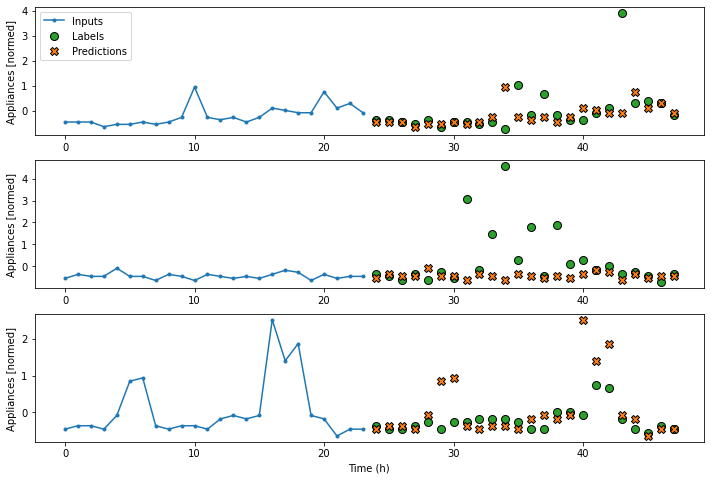

In [65]:
multi_window.plot(repeat_baseline)

### Linear - Single Shot

In [66]:
multi_linear_model = Sequential([
    # Take last time step
    Lambda(lambda x: x[:, -1:, :]),    # Shape [batch, time, features] => [batch, 1, features]
    Dense(OUT_STEPS*num_features,      # Shape [batch, 1, out_steps*features]
          kernel_initializer=tf.initializers.zeros),      
    Reshape([OUT_STEPS, num_features]) #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_linear_model, multi_window)

multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 3s 18ms/step - loss: 0.6998 - mean_absolute_error: 0.6584 - val_loss: 0.9447 - val_mean_absolute_error: 0.7264
Epoch 2/50
71/71 [==============================] - 2s 25ms/step - loss: 0.4657 - mean_absolute_error: 0.5158 - val_loss: 0.7168 - val_mean_absolute_error: 0.6074
Epoch 3/50
71/71 [==============================] - 1s 15ms/step - loss: 0.4081 - mean_absolute_error: 0.4730 - val_loss: 0.6595 - val_mean_absolute_error: 0.5749
Epoch 4/50
71/71 [==============================] - 1s 17ms/step - loss: 0.3797 - mean_absolute_error: 0.4511 - val_loss: 0.6280 - val_mean_absolute_error: 0.5569
Epoch 5/50
71/71 [==============================] - 1s 16ms/step - loss: 0.3621 - mean_absolute_error: 0.4370 - val_loss: 0.6077 - val_mean_absolute_error: 0.5455
Epoch 6/50
71/71 [==============================] - 1s 14ms/step - loss: 0.3497 - mean_absolute_error: 0.4266 - val_loss: 0.5900 - val_mean_absolute_error: 0.5345
Epoch 7/50
71/71 [====

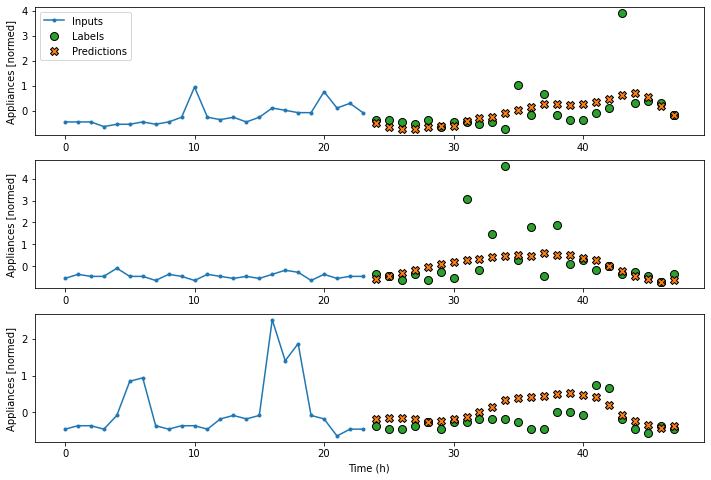

In [67]:
multi_window.plot(multi_linear_model)

### Dense - Single Shot

In [68]:
multi_dense_model = Sequential([
    Lambda(lambda x: x[:, -1:, :]),
    Dense(512, activation='relu'),
    Dense(OUT_STEPS*num_features, 
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 3s 22ms/step - loss: 0.4641 - mean_absolute_error: 0.5014 - val_loss: 0.6368 - val_mean_absolute_error: 0.5509
Epoch 2/50
71/71 [==============================] - 1s 18ms/step - loss: 0.3000 - mean_absolute_error: 0.3773 - val_loss: 0.6195 - val_mean_absolute_error: 0.5312
Epoch 3/50
71/71 [==============================] - 2s 21ms/step - loss: 0.2778 - mean_absolute_error: 0.3555 - val_loss: 0.5855 - val_mean_absolute_error: 0.5147
Epoch 4/50
71/71 [==============================] - 2s 29ms/step - loss: 0.2649 - mean_absolute_error: 0.3438 - val_loss: 0.5935 - val_mean_absolute_error: 0.5167
Epoch 5/50
71/71 [==============================] - 2s 22ms/step - loss: 0.2549 - mean_absolute_error: 0.3348 - val_loss: 0.6063 - val_mean_absolute_error: 0.5190
Epoch 6/50
20/20 [==============================] - 0s 11ms/step - loss: 0.6003 - mean_absolute_error: 0.5205


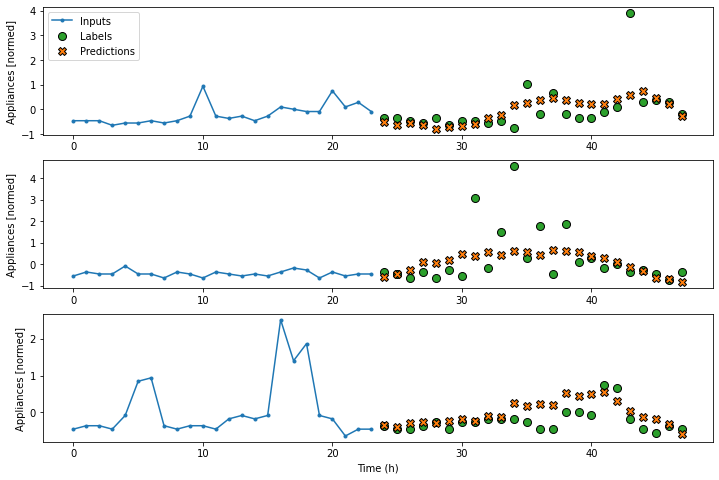

In [69]:
multi_window.plot(multi_dense_model)

### CNN - Single Shot

In [70]:
CONV_WIDTH = 3

multi_conv_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),         # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Conv1D(256, 
           activation='relu', 
           kernel_size=(CONV_WIDTH)),                # Shape [batch, 1, conv_units]
    Dense(OUT_STEPS*num_features, 
          kernel_initializer=tf.initializers.zeros), #Shape [batch, 1, out_step*features]
    Reshape([OUT_STEPS, num_features])               #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 2s 19ms/step - loss: 0.4859 - mean_absolute_error: 0.5166 - val_loss: 0.6419 - val_mean_absolute_error: 0.5670
Epoch 2/50
71/71 [==============================] - 2s 22ms/step - loss: 0.3087 - mean_absolute_error: 0.3863 - val_loss: 0.5915 - val_mean_absolute_error: 0.5327
Epoch 3/50
71/71 [==============================] - 2s 22ms/step - loss: 0.2831 - mean_absolute_error: 0.3628 - val_loss: 0.6017 - val_mean_absolute_error: 0.5371
Epoch 4/50
71/71 [==============================] - 1s 17ms/step - loss: 0.2671 - mean_absolute_error: 0.3487 - val_loss: 0.5881 - val_mean_absolute_error: 0.5282
Epoch 5/50
71/71 [==============================] - 1s 16ms/step - loss: 0.2554 - mean_absolute_error: 0.3386 - val_loss: 0.5947 - val_mean_absolute_error: 0.5274
Epoch 6/50
71/71 [==============================] - 1s 14ms/step - loss: 0.2459 - mean_absolute_error: 0.3304 - val_loss: 0.6054 - val_mean_absolute_error: 0.5337
Epoch 7/50
20/20 [====

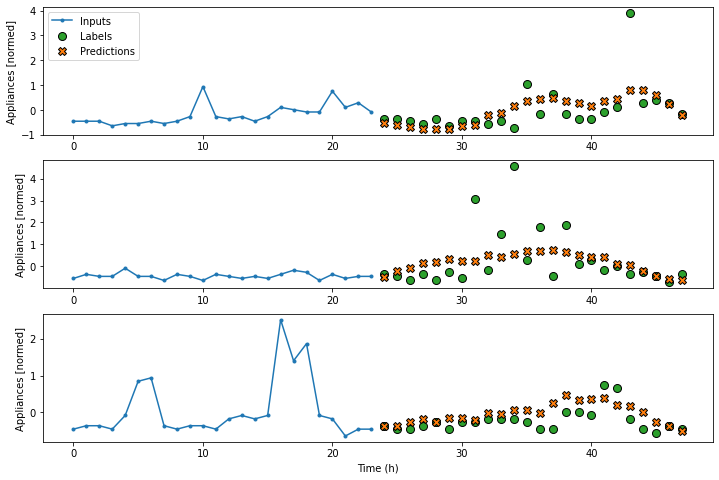

In [71]:
multi_window.plot(multi_conv_model)

### LSTM - Single Shot

In [72]:
multi_lstm_model = Sequential([
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features,
          kernel_initializer=tf.initializers.zeros),
    Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)


multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 11s 47ms/step - loss: 0.7739 - mean_absolute_error: 0.6937 - val_loss: 1.6045 - val_mean_absolute_error: 0.9584
Epoch 2/50
71/71 [==============================] - 2s 29ms/step - loss: 0.5380 - mean_absolute_error: 0.5589 - val_loss: 1.3571 - val_mean_absolute_error: 0.8699
Epoch 3/50
71/71 [==============================] - 2s 31ms/step - loss: 0.4604 - mean_absolute_error: 0.5095 - val_loss: 1.2332 - val_mean_absolute_error: 0.8204
Epoch 4/50
71/71 [==============================] - 2s 29ms/step - loss: 0.3774 - mean_absolute_error: 0.4506 - val_loss: 1.0910 - val_mean_absolute_error: 0.7643
Epoch 5/50
71/71 [==============================] - 2s 30ms/step - loss: 0.3304 - mean_absolute_error: 0.4113 - val_loss: 1.0507 - val_mean_absolute_error: 0.7509
Epoch 6/50
71/71 [==============================] - 2s 32ms/step - loss: 0.3098 - mean_absolute_error: 0.3940 - val_loss: 1.0529 - val_mean_absolute_error: 0.7532
Epoch 7/50
71/71 [===

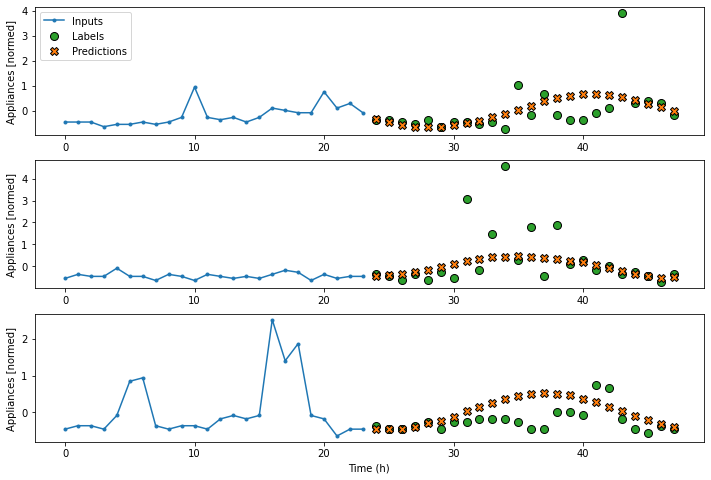

In [73]:
multi_window.plot(multi_lstm_model)

### CNN + LSTM - Single Shot

In [74]:
CONV_WIDTH = 3

multi_conv_model = Sequential([
    Lambda(lambda x: x[:, -CONV_WIDTH:, :]),         # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    Conv1D(256, 
           activation='relu', 
           kernel_size=(CONV_WIDTH)),                # Shape [batch, 1, conv_units]
    LSTM(32, return_sequences=True),
    LSTM(32, return_sequences=False),
    Dense(OUT_STEPS*num_features, 
          kernel_initializer=tf.initializers.zeros), #Shape [batch, 1, out_step*features]
    Reshape([OUT_STEPS, num_features])               #Shape [batch, out_steps, features]
])

history = compile_and_fit(multi_conv_model, multi_window)

multi_val_performance['CNN+LSTM'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['CNN+LSTM'] = multi_conv_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
71/71 [==============================] - 11s 28ms/step - loss: 0.8592 - mean_absolute_error: 0.7362 - val_loss: 1.6608 - val_mean_absolute_error: 0.9644
Epoch 2/50
71/71 [==============================] - 1s 14ms/step - loss: 0.5799 - mean_absolute_error: 0.5803 - val_loss: 1.3378 - val_mean_absolute_error: 0.8682
Epoch 3/50
71/71 [==============================] - 1s 14ms/step - loss: 0.5173 - mean_absolute_error: 0.5419 - val_loss: 1.2310 - val_mean_absolute_error: 0.8372
Epoch 4/50
71/71 [==============================] - 1s 12ms/step - loss: 0.4783 - mean_absolute_error: 0.5182 - val_loss: 1.1781 - val_mean_absolute_error: 0.8088
Epoch 5/50
71/71 [==============================] - 1s 15ms/step - loss: 0.4262 - mean_absolute_error: 0.4846 - val_loss: 1.0963 - val_mean_absolute_error: 0.7797
Epoch 6/50
71/71 [==============================] - 1s 15ms/step - loss: 0.3657 - mean_absolute_error: 0.4404 - val_loss: 0.9986 - val_mean_absolute_error: 0.7277
Epoch 7/50
71/71 [===

### LSTM - Autoregressive

In [75]:
class FeedBack(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(num_features)
        
    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)
        
        return prediction, state
    
    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)
        
        predictions.append(prediction)
        
        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x,
                                     states=state,
                                     training=training)
            prediction = self.dense(x)
            predictions.append(prediction)
            
        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])
        
        return predictions

Epoch 1/50
71/71 [==============================] - 15s 60ms/step - loss: 0.7732 - mean_absolute_error: 0.6869 - val_loss: 1.4954 - val_mean_absolute_error: 0.9025
Epoch 2/50
71/71 [==============================] - 3s 37ms/step - loss: 0.5413 - mean_absolute_error: 0.5589 - val_loss: 1.3840 - val_mean_absolute_error: 0.8697
Epoch 3/50
71/71 [==============================] - 3s 38ms/step - loss: 0.4884 - mean_absolute_error: 0.5267 - val_loss: 1.3271 - val_mean_absolute_error: 0.8466
Epoch 4/50
71/71 [==============================] - 3s 35ms/step - loss: 0.4081 - mean_absolute_error: 0.4746 - val_loss: 1.1980 - val_mean_absolute_error: 0.8012
Epoch 5/50
71/71 [==============================] - 2s 27ms/step - loss: 0.3602 - mean_absolute_error: 0.4370 - val_loss: 1.1610 - val_mean_absolute_error: 0.7893
Epoch 6/50
71/71 [==============================] - 2s 29ms/step - loss: 0.3357 - mean_absolute_error: 0.4169 - val_loss: 1.1527 - val_mean_absolute_error: 0.7899
Epoch 7/50
71/71 [===

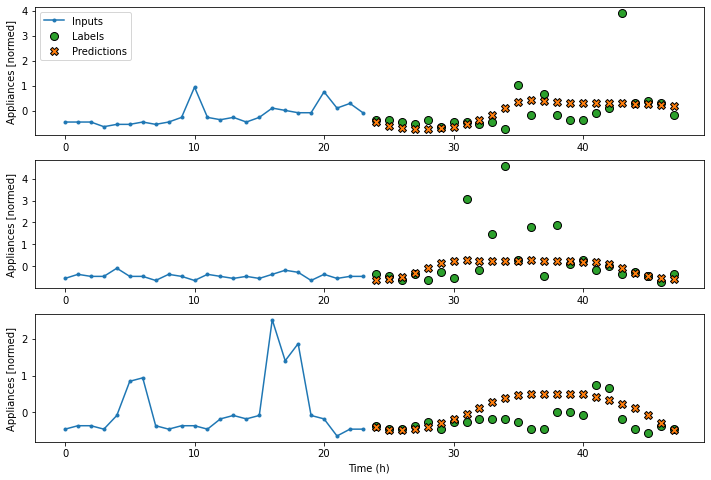

In [76]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

history = compile_and_fit(feedback_model, multi_window)

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)

multi_window.plot(feedback_model)

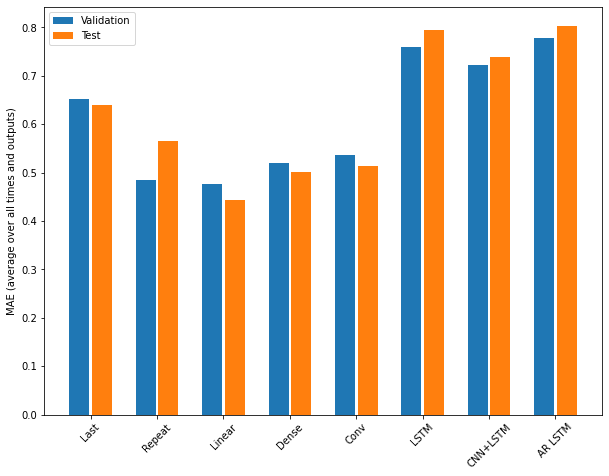

In [77]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
plt.legend(loc='best')
plt.show()

In [78]:
for name, value in multi_performance.items():
    print(f'{name:12s}: {value[1]:0.4f}')

Last        : 0.6389
Repeat      : 0.5648
Linear      : 0.4434
Dense       : 0.5016
Conv        : 0.5138
LSTM        : 0.7948
CNN+LSTM    : 0.7397
AR LSTM     : 0.8021
